In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("AirForceRetention").getOrCreate()

# Load CSV files into Spark DataFrames using corrected File API paths
df_defense_spending = spark.read.csv("dbfs:/FileStore/defense_spending_compared_to_gov_spending_on_paying_individuals.csv", header=True, inferSchema=True)
df_airforce_personnel = spark.read.csv("dbfs:/FileStore/airforce_personnel_breakdown.csv", header=True, inferSchema=True)
df_military_pay = spark.read.csv("dbfs:/FileStore/FY2013_Military_Annual_Composite_Pay.csv", header=True, inferSchema=True)
df_personnel = spark.read.csv("dbfs:/FileStore/military_personnel_numbers.csv", header=True, inferSchema=True)
df_outlays = spark.read.csv("dbfs:/FileStore/national_defense_outlays_and_payments_to_individuals.csv", header=True, inferSchema=True)
df_officer_pay = spark.read.csv("dbfs:/FileStore/officer_enlisted_pay.csv", header=True, inferSchema=True)
df_budget = spark.read.csv("dbfs:/FileStore/spending_on_various_af_budget_categories.csv", header=True, inferSchema=True)
df_toa = spark.read.csv("dbfs:/FileStore/total_obligational_authority_by_service_component.csv", header=True, inferSchema=True)

# Show first few rows for verification
df_personnel.show(5)

+-----------+------+------+---------+--------+
|FISCAL YEAR|  ARMY|  NAVY|AIR FORCE|DEFENSE-|
+-----------+------+------+---------+--------+
|     OTHER"| TOTAL|  NULL|     NULL|    NULL|
|       1999|65,773|78,598|   79,158|  37,850|
|       2000|70,336|87,204|   82,092|  41,602|
|       2001|73,800|90,444|   84,827|  41,909|
|       2002|83,319|98,547|   95,561|  54,688|
+-----------+------+------+---------+--------+
only showing top 5 rows



Creating Database for project

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS airforce_analysis;
USE airforce_analysis;

Registering Hive tables

In [0]:
%sql
CREATE TABLE defense_spending (
    fiscal_year INT,
    national_defense_outlays DOUBLE,
    payments_to_individuals DOUBLE
)
USING CSV
OPTIONS (path "dbfs:/FileStore/defense_spending_compared_to_gov_spending_on_paying_individuals.csv", header "true", inferSchema "true");

CREATE TABLE airforce_personnel_breakdown (
    fiscal_year INT,
    regular_air_force INT,
    air_force_reserve INT,
    air_national_guard INT,
    total_air_force INT
)
USING CSV
OPTIONS (path "dbfs:/FileStore/airforce_personnel_breakdown.csv", header "true", inferSchema "true");

CREATE TABLE military_pay (
    rank STRING,
    annual_pay DOUBLE
)
USING CSV
OPTIONS (path "dbfs:/FileStore/FY2013_Military_Annual_Composite_Pay.csv", header "true", inferSchema "true");

CREATE TABLE personnel_numbers (
    fiscal_year INT,
    army INT,
    navy INT,
    air_force INT,
    defense_other INT,
    total INT
)
USING CSV
OPTIONS (path "dbfs:/FileStore/military_personnel_numbers.csv", header "true", inferSchema "true");

CREATE TABLE officer_enlisted_pay (
    rank STRING,
    pay DOUBLE
)
USING CSV
OPTIONS (path "dbfs:/FileStore/officer_enlisted_pay.csv", header "true", inferSchema "true");

CREATE TABLE airforce_budget_categories (
    fiscal_year INT,
    category STRING,
    spending DOUBLE
)
USING CSV
OPTIONS (path "dbfs:/FileStore/spending_on_various_af_budget_categories.csv", header "true", inferSchema "true");

CREATE TABLE total_obligational_authority (
    fiscal_year INT,
    army DOUBLE,
    navy DOUBLE,
    air_force DOUBLE,
    defense_other DOUBLE,
    total DOUBLE
)
USING CSV
OPTIONS (path "dbfs:/FileStore/total_obligational_authority_by_service_component.csv", header "true", inferSchema "true");


org.apache.spark.sql.catalyst.analysis.TableAlreadyExistsException: [TABLE_OR_VIEW_ALREADY_EXISTS] Cannot create table or view `spark_catalog`.`airforce_analysis`.`defense_spending` because it already exists.
Choose a different name, drop or replace the existing object, add the IF NOT EXISTS clause to tolerate pre-existing objects, or add the OR REFRESH clause to refresh the existing streaming table. SQLSTATE: 42P07
	at org.apache.spark.sql.errors.QueryCompilationErrors$.tableAlreadyExistsError(QueryCompilationErrors.scala:3003)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableCommand.run(createDataSourceTables.scala:62)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.$anonfun$sideEffectResult$2(commands.scala:84)
	at org.apache.spark.sql.execution.SparkPlan.runCommandWithAetherOff(SparkPlan.scala:178)
	at org.apache.spark.sql.execution.SparkPlan.runCommandInAetherOrSpark(SparkPlan.scala:189)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.$

In [0]:
%sql
SHOW TABLES;


database,tableName,isTemporary
airforce_analysis,airforce_budget_categories,false
airforce_analysis,airforce_personnel_breakdown,false
airforce_analysis,defense_spending,false
airforce_analysis,military_pay,false
airforce_analysis,officer_enlisted_pay,false
airforce_analysis,personnel_numbers,false
airforce_analysis,total_obligational_authority,false
,airforce_personnel_cleaned,true
,defense_spending_cleaned,true
,military_pay_cleaned,true


In [0]:
df_budget.printSchema()


root
 |-- FY: string (nullable = true)
 |-- MILITARY COMPENSATION: string (nullable = true)
 |-- Unknown_Column2: double (nullable = true)
 |-- Unknown_Column3: double (nullable = true)
 |-- Unknown_Column4: double (nullable = true)
 |-- GENERA: double (nullable = true)



^^ issues with coloumn naming, begin cleaning and renaming columns for ease later

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("AirForceRetention").getOrCreate()

# Reload datasets from DBFS
df_defense_spending = spark.read.csv("dbfs:/FileStore/defense_spending_compared_to_gov_spending_on_paying_individuals.csv", header=True, inferSchema=True)
df_airforce_personnel = spark.read.csv("dbfs:/FileStore/airforce_personnel_breakdown.csv", header=True, inferSchema=True)
df_military_pay = spark.read.csv("dbfs:/FileStore/FY2013_Military_Annual_Composite_Pay.csv", header=True, inferSchema=True)
df_personnel = spark.read.csv("dbfs:/FileStore/military_personnel_numbers.csv", header=True, inferSchema=True)
df_officer_pay = spark.read.csv("dbfs:/FileStore/officer_enlisted_pay.csv", header=True, inferSchema=True)
df_budget = spark.read.csv("dbfs:/FileStore/spending_on_various_af_budget_categories.csv", header=True, inferSchema=True)
df_toa = spark.read.csv("dbfs:/FileStore/total_obligational_authority_by_service_component.csv", header=True, inferSchema=True)

df_defense_spending_cleaned = df_defense_spending.withColumnRenamed("FISCAL YEAR", "fiscal_year") \
    .withColumnRenamed("NATIONAL DEFENSE ", "national_defense_outlays")

df_airforce_personnel_cleaned = df_airforce_personnel.withColumnRenamed("FISCAL YEAR", "fiscal_year") \
    .withColumnRenamed("REGULAR ", "regular_air_force")

df_military_pay_cleaned = df_military_pay.withColumnRenamed("GRADE", "rank") \
    .withColumnRenamed("BASIC ", "base_pay")

df_personnel_cleaned = df_personnel.withColumnRenamed("FISCAL YEAR", "fiscal_year") \
    .withColumnRenamed("DEFENSE-", "defense_other")

df_officer_pay_cleaned = df_officer_pay.withColumnRenamed("Pay Grade", "pay_grade") \
    .withColumnRenamed("2 or less", "pay_under_2") \
    .withColumnRenamed("Over 2", "pay_over_2") \
    .withColumnRenamed("Over 3", "pay_over_3") \
    .withColumnRenamed("Over 4", "pay_over_4") \
    .withColumnRenamed("Over 6", "pay_over_6") \
    .withColumnRenamed("Over 8", "pay_over_8") \
    .withColumnRenamed("Over 10", "pay_over_10")

df_toa_cleaned = df_toa.withColumnRenamed("FISCAL YEAR", "fiscal_year") \
    .withColumnRenamed("DEFENSE-", "defense_other")

df_defense_spending_cleaned.printSchema()
df_airforce_personnel_cleaned.printSchema()
df_military_pay_cleaned.printSchema()
df_personnel_cleaned.printSchema()
df_officer_pay_cleaned.printSchema()
df_toa_cleaned.printSchema()


root
 |-- fiscal_year: string (nullable = true)
 |-- national_defense_outlays: string (nullable = true)

root
 |-- FY: string (nullable = true)
 |-- regular_air_force: string (nullable = true)

root
 |-- rank: string (nullable = true)
 |-- base_pay: string (nullable = true)

root
 |-- fiscal_year: string (nullable = true)
 |-- ARMY: string (nullable = true)
 |-- NAVY: string (nullable = true)
 |-- AIR FORCE: string (nullable = true)
 |-- defense_other: string (nullable = true)

root
 |-- pay_grade: string (nullable = true)
 |-- pay_under_2: string (nullable = true)
 |-- pay_over_2: string (nullable = true)
 |-- pay_over_3: string (nullable = true)
 |-- pay_over_4: string (nullable = true)
 |-- pay_over_6: string (nullable = true)
 |-- pay_over_8: string (nullable = true)
 |-- pay_over_10: string (nullable = true)

root
 |-- fiscal_year: string (nullable = true)
 |-- ARMY: string (nullable = true)
 |-- NAVY: string (nullable = true)
 |-- AIR FORCE: string (nullable = true)
 |-- defense_

In [0]:
from pyspark.sql.functions import col

# Fix defense spending data
df_defense_spending_cleaned = df_defense_spending_cleaned.withColumn("national_defense_outlays", col("national_defense_outlays").cast("double"))

# Fix Air Force personnel data (Ensure FY is fiscal_year)
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.withColumnRenamed("FY", "fiscal_year") \
    .withColumn("regular_air_force", col("regular_air_force").cast("int"))

# Fix military pay data
df_military_pay_cleaned = df_military_pay_cleaned.withColumn("base_pay", col("base_pay").cast("double"))

# Fix personnel data
df_personnel_cleaned = df_personnel_cleaned.withColumn("ARMY", col("ARMY").cast("int")) \
    .withColumn("NAVY", col("NAVY").cast("int")) \
    .withColumn("AIR FORCE", col("AIR FORCE").cast("int")) \
    .withColumn("defense_other", col("defense_other").cast("int"))

# Fix officer pay data
df_officer_pay_cleaned = df_officer_pay_cleaned.withColumn("pay_under_2", col("pay_under_2").cast("double")) \
    .withColumn("pay_over_2", col("pay_over_2").cast("double")) \
    .withColumn("pay_over_3", col("pay_over_3").cast("double")) \
    .withColumn("pay_over_4", col("pay_over_4").cast("double")) \
    .withColumn("pay_over_6", col("pay_over_6").cast("double")) \
    .withColumn("pay_over_8", col("pay_over_8").cast("double")) \
    .withColumn("pay_over_10", col("pay_over_10").cast("double"))

# Fix total obligational authority (TOA) data
df_toa_cleaned = df_toa_cleaned.withColumn("ARMY", col("ARMY").cast("double")) \
    .withColumn("NAVY", col("NAVY").cast("double")) \
    .withColumn("AIR FORCE", col("AIR FORCE").cast("double")) \
    .withColumn("defense_other", col("defense_other").cast("double"))

df_defense_spending_cleaned.printSchema()
df_airforce_personnel_cleaned.printSchema()
df_military_pay_cleaned.printSchema()
df_personnel_cleaned.printSchema()
df_officer_pay_cleaned.printSchema()
df_toa_cleaned.printSchema()


root
 |-- fiscal_year: string (nullable = true)
 |-- national_defense_outlays: double (nullable = true)

root
 |-- fiscal_year: string (nullable = true)
 |-- regular_air_force: integer (nullable = true)

root
 |-- rank: string (nullable = true)
 |-- base_pay: double (nullable = true)

root
 |-- fiscal_year: string (nullable = true)
 |-- ARMY: integer (nullable = true)
 |-- NAVY: integer (nullable = true)
 |-- AIR FORCE: integer (nullable = true)
 |-- defense_other: integer (nullable = true)

root
 |-- pay_grade: string (nullable = true)
 |-- pay_under_2: double (nullable = true)
 |-- pay_over_2: double (nullable = true)
 |-- pay_over_3: double (nullable = true)
 |-- pay_over_4: double (nullable = true)
 |-- pay_over_6: double (nullable = true)
 |-- pay_over_8: double (nullable = true)
 |-- pay_over_10: double (nullable = true)

root
 |-- fiscal_year: string (nullable = true)
 |-- ARMY: double (nullable = true)
 |-- NAVY: double (nullable = true)
 |-- AIR FORCE: double (nullable = true)

Checking for missing values

In [0]:
from pyspark.sql.functions import col, count, when

# Function to check missing values for each DataFrame
def check_missing_values(df, df_name):
    print(f"Missing values in {df_name}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Check missing values in each dataset
check_missing_values(df_defense_spending_cleaned, "defense_spending_cleaned")
check_missing_values(df_airforce_personnel_cleaned, "airforce_personnel_cleaned")
check_missing_values(df_military_pay_cleaned, "military_pay_cleaned")
check_missing_values(df_personnel_cleaned, "personnel_cleaned")
check_missing_values(df_officer_pay_cleaned, "officer_enlisted_pay_cleaned")
check_missing_values(df_toa_cleaned, "total_obligational_authority_cleaned")


Missing values in defense_spending_cleaned:
+-----------+------------------------+
|fiscal_year|national_defense_outlays|
+-----------+------------------------+
|         61|                      63|
+-----------+------------------------+

Missing values in airforce_personnel_cleaned:
+-----------+-----------------+
|fiscal_year|regular_air_force|
+-----------+-----------------+
|          0|               20|
+-----------+-----------------+

Missing values in military_pay_cleaned:
+----+--------+
|rank|base_pay|
+----+--------+
|   0|      38|
+----+--------+

Missing values in personnel_cleaned:
+-----------+----+----+---------+-------------+
|fiscal_year|ARMY|NAVY|AIR FORCE|defense_other|
+-----------+----+----+---------+-------------+
|          0|  16|  16|       16|           16|
+-----------+----+----+---------+-------------+

Missing values in officer_enlisted_pay_cleaned:
+---------+-----------+----------+----------+----------+----------+----------+-----------+
|pay_grade|pay_

In [0]:
from pyspark.sql.functions import lit

# Fill missing values for numerical columns with 0
df_defense_spending_cleaned = df_defense_spending_cleaned.fillna({'national_defense_outlays': 0})
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.fillna({'regular_air_force': 0})
df_military_pay_cleaned = df_military_pay_cleaned.fillna({'base_pay': 0})
df_personnel_cleaned = df_personnel_cleaned.fillna({'ARMY': 0, 'NAVY': 0, 'AIR FORCE': 0, 'defense_other': 0})
df_officer_pay_cleaned = df_officer_pay_cleaned.fillna({'pay_under_2': 0, 'pay_over_2': 0, 'pay_over_10': 0})
df_toa_cleaned = df_toa_cleaned.fillna({'ARMY': 0, 'NAVY': 0, 'AIR FORCE': 0, 'defense_other': 0})

# Drop rows where fiscal_year is null
df_defense_spending_cleaned = df_defense_spending_cleaned.dropna(subset=["fiscal_year"])
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.dropna(subset=["fiscal_year"])
df_military_pay_cleaned = df_military_pay_cleaned.dropna(subset=["rank"])
df_personnel_cleaned = df_personnel_cleaned.dropna(subset=["fiscal_year"])
df_officer_pay_cleaned = df_officer_pay_cleaned.dropna(subset=["pay_grade"])
df_toa_cleaned = df_toa_cleaned.dropna(subset=["fiscal_year"])


Removing duplicates

In [0]:
df_defense_spending_cleaned = df_defense_spending_cleaned.dropDuplicates()
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.dropDuplicates()
df_military_pay_cleaned = df_military_pay_cleaned.dropDuplicates()
df_personnel_cleaned = df_personnel_cleaned.dropDuplicates()
df_officer_pay_cleaned = df_officer_pay_cleaned.dropDuplicates()
df_toa_cleaned = df_toa_cleaned.dropDuplicates()


In [0]:
df_defense_spending_cleaned = df_defense_spending_cleaned.withColumn("fiscal_year", col("fiscal_year").cast("int"))
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.withColumn("fiscal_year", col("fiscal_year").cast("int"))
df_personnel_cleaned = df_personnel_cleaned.withColumn("fiscal_year", col("fiscal_year").cast("int"))
df_toa_cleaned = df_toa_cleaned.withColumn("fiscal_year", col("fiscal_year").cast("int"))


In [0]:
df_personnel_cleaned = df_personnel_cleaned.withColumn("total_military_personnel", 
    col("ARMY") + col("NAVY") + col("AIR FORCE"))


Yearly Growth Rate column for personnel

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, round

# Define window for calculating previous year's personnel
windowSpec = Window().partitionBy().orderBy("fiscal_year")

# Compute previous year's total personnel
df_personnel_cleaned = df_personnel_cleaned.withColumn("prev_total_military_personnel",
    lag("total_military_personnel").over(windowSpec))

# Compute percentage change from the previous year
df_personnel_cleaned = df_personnel_cleaned.withColumn("personnel_growth_rate",
    round(((col("total_military_personnel") - col("prev_total_military_personnel")) / 
          col("prev_total_military_personnel")) * 100, 2))

# Drop the temporary column
df_personnel_cleaned = df_personnel_cleaned.drop("prev_total_military_personnel")


In [0]:
df_defense_spending_cleaned.createOrReplaceTempView("defense_spending_cleaned")
df_airforce_personnel_cleaned.createOrReplaceTempView("airforce_personnel_cleaned")
df_military_pay_cleaned.createOrReplaceTempView("military_pay_cleaned")
df_personnel_cleaned.createOrReplaceTempView("personnel_cleaned")
df_officer_pay_cleaned.createOrReplaceTempView("officer_enlisted_pay_cleaned")
df_toa_cleaned.createOrReplaceTempView("total_obligational_authority_cleaned")


Checking for categorical data

In [0]:
for df_name, df in [
    ("defense_spending_cleaned", df_defense_spending_cleaned),
    ("airforce_personnel_cleaned", df_airforce_personnel_cleaned),
    ("military_pay_cleaned", df_military_pay_cleaned),
    ("personnel_cleaned", df_personnel_cleaned),
    ("officer_enlisted_pay_cleaned", df_officer_pay_cleaned),
    ("total_obligational_authority_cleaned", df_toa_cleaned)
]:
    print(f"Schema for {df_name}:")
    df.printSchema()


Schema for defense_spending_cleaned:
root
 |-- fiscal_year: integer (nullable = true)
 |-- national_defense_outlays: double (nullable = false)

Schema for airforce_personnel_cleaned:
root
 |-- fiscal_year: integer (nullable = true)
 |-- regular_air_force: integer (nullable = false)

Schema for military_pay_cleaned:
root
 |-- rank: string (nullable = true)
 |-- base_pay: double (nullable = false)

Schema for personnel_cleaned:
root
 |-- fiscal_year: integer (nullable = true)
 |-- ARMY: integer (nullable = false)
 |-- NAVY: integer (nullable = false)
 |-- AIR FORCE: integer (nullable = false)
 |-- defense_other: integer (nullable = false)
 |-- total_military_personnel: integer (nullable = false)
 |-- personnel_growth_rate: double (nullable = true)

Schema for officer_enlisted_pay_cleaned:
root
 |-- pay_grade: string (nullable = true)
 |-- pay_under_2: double (nullable = false)
 |-- pay_over_2: double (nullable = false)
 |-- pay_over_3: double (nullable = true)
 |-- pay_over_4: double (nu

Only two categorical columns

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# One-Hot Encoding for "rank" in military_pay_cleaned
rank_indexer = StringIndexer(inputCol="rank", outputCol="rank_indexed")
rank_encoder = OneHotEncoder(inputCol="rank_indexed", outputCol="rank_encoded")

# One-Hot Encoding for "pay_grade" in officer_enlisted_pay_cleaned
pay_grade_indexer = StringIndexer(inputCol="pay_grade", outputCol="pay_grade_indexed")
pay_grade_encoder = OneHotEncoder(inputCol="pay_grade_indexed", outputCol="pay_grade_encoded")

# Define pipelines
rank_pipeline = Pipeline(stages=[rank_indexer, rank_encoder])
pay_grade_pipeline = Pipeline(stages=[pay_grade_indexer, pay_grade_encoder])

# Apply transformations
df_military_pay_encoded = rank_pipeline.fit(df_military_pay_cleaned).transform(df_military_pay_cleaned)
df_officer_pay_encoded = pay_grade_pipeline.fit(df_officer_pay_cleaned).transform(df_officer_pay_cleaned)

# Drop original categorical columns after encoding
df_military_pay_encoded = df_military_pay_encoded.drop("rank", "rank_indexed")
df_officer_pay_encoded = df_officer_pay_encoded.drop("pay_grade", "pay_grade_indexed")

# Show encoded data
df_military_pay_encoded.show(5)
df_officer_pay_encoded.show(5)


+--------+---------------+
|base_pay|   rank_encoded|
+--------+---------------+
|     0.0|(34,[16],[1.0])|
|     0.0|(34,[12],[1.0])|
|     0.0| (34,[5],[1.0])|
|     0.0|(34,[28],[1.0])|
|     0.0| (34,[7],[1.0])|
+--------+---------------+
only showing top 5 rows

+-----------+----------+----------+----------+----------+----------+-----------+-----------------+
|pay_under_2|pay_over_2|pay_over_3|pay_over_4|pay_over_6|pay_over_8|pay_over_10|pay_grade_encoded|
+-----------+----------+----------+----------+----------+----------+-----------+-----------------+
|        0.0|       0.0|      NULL|      NULL|      NULL|      NULL|        0.0|   (21,[4],[1.0])|
|        0.0|       0.0|      NULL|      NULL|      NULL|      NULL|        0.0|   (21,[5],[1.0])|
|        0.0|       0.0|      NULL|      NULL|      NULL|      NULL|        0.0|   (21,[2],[1.0])|
|        0.0|       0.0|      NULL|      NULL|      NULL|      NULL|        0.0|   (21,[8],[1.0])|
|        0.0|       0.0|      NULL|    

Parquet format for saving data

In [0]:
output_path = "dbfs:/FileStore/optimized_data/"

df_defense_spending_cleaned.write.mode("overwrite").parquet(output_path + "defense_spending_cleaned.parquet")
df_airforce_personnel_cleaned.write.mode("overwrite").parquet(output_path + "airforce_personnel_cleaned.parquet")
df_military_pay_encoded.write.mode("overwrite").parquet(output_path + "military_pay_cleaned.parquet")
df_personnel_cleaned.write.mode("overwrite").parquet(output_path + "personnel_cleaned.parquet")
df_officer_pay_encoded.write.mode("overwrite").parquet(output_path + "officer_enlisted_pay_cleaned.parquet")
df_toa_cleaned.write.mode("overwrite").parquet(output_path + "total_obligational_authority_cleaned.parquet")


In [0]:
df_test = spark.read.parquet(output_path + "military_pay_cleaned.parquet")
df_test.printSchema()
df_test.show(5)


root
 |-- base_pay: double (nullable = true)
 |-- rank_encoded: vector (nullable = true)

+--------+---------------+
|base_pay|   rank_encoded|
+--------+---------------+
|     0.0|(34,[16],[1.0])|
|     0.0|(34,[12],[1.0])|
|     0.0| (34,[5],[1.0])|
|     0.0|(34,[28],[1.0])|
|     0.0| (34,[7],[1.0])|
+--------+---------------+
only showing top 5 rows



In [0]:
# Reload CSVs without header=True to inspect the actual structure
df_defense_spending = spark.read.csv("dbfs:/FileStore/defense_spending_compared_to_gov_spending_on_paying_individuals.csv", header=False, inferSchema=True)
df_airforce_personnel = spark.read.csv("dbfs:/FileStore/airforce_personnel_breakdown.csv", header=False, inferSchema=True)
df_military_pay = spark.read.csv("dbfs:/FileStore/FY2013_Military_Annual_Composite_Pay.csv", header=False, inferSchema=True)
df_personnel = spark.read.csv("dbfs:/FileStore/military_personnel_numbers.csv", header=False, inferSchema=True)
df_officer_pay = spark.read.csv("dbfs:/FileStore/officer_enlisted_pay.csv", header=False, inferSchema=True)
df_budget = spark.read.csv("dbfs:/FileStore/spending_on_various_af_budget_categories.csv", header=False, inferSchema=True)
df_toa = spark.read.csv("dbfs:/FileStore/total_obligational_authority_by_service_component.csv", header=False, inferSchema=True)

# Show first few rows to check the true structure
df_defense_spending.show(10)
df_airforce_personnel.show(10)
df_military_pay.show(10)
df_personnel.show(10)
df_officer_pay.show(10)
df_budget.show(10)
df_toa.show(10)


+-------------+-------------------+
|          _c0|                _c1|
+-------------+-------------------+
|  FISCAL YEAR|NATIONAL DEFENSE \n|
|     OUTLAYS"|     PAYMENTS TO \n|
|INDIVIDUALS1"|               NULL|
|         1998|                3.1|
|         1999|                  3|
|         2000|                  3|
|         2001|                  3|
|         2002|                3.3|
|         2003|                3.7|
|         2004|                3.9|
+-------------+-------------------+
only showing top 10 rows

+---------------+--------------+
|            _c0|           _c1|
+---------------+--------------+
|             FY|    REGULAR \n|
|AIR FORCE (AF)"|   AIR FORCE\n|
| RESERVE (AFR)"|AIR NATIONAL\n|
|   GUARD (ANG)"|       TOTAL\n|
|     AIR FORCE"|          NULL|
|           1998|         4,447|
|           1999|         4,413|
|           2000|         4,401|
|           2001|         4,339|
|           2002|         4,387|
+---------------+--------------+
only sho

In [0]:
# Remove rows that contain extra headers by filtering fiscal years
df_defense_spending_cleaned = df_defense_spending.filter(df_defense_spending["_c0"].rlike("^[0-9]{4}$"))
df_airforce_personnel_cleaned = df_airforce_personnel.filter(df_airforce_personnel["_c0"].rlike("^[0-9]{4}$"))
df_military_pay_cleaned = df_military_pay.filter(df_military_pay["_c0"].rlike("^[A-Z]-[0-9]+$"))
df_personnel_cleaned = df_personnel.filter(df_personnel["_c0"].rlike("^[0-9]{4}$"))
df_officer_pay_cleaned = df_officer_pay.filter(df_officer_pay["_c0"].rlike("^[A-Z]-[0-9]+$"))
df_budget_cleaned = df_budget.filter(df_budget["_c0"].rlike("^[0-9]{4}$"))
df_toa_cleaned = df_toa.filter(df_toa["_c0"].rlike("^[0-9]{4}$"))

# Verify cleaned data
df_defense_spending_cleaned.show(10)
df_airforce_personnel_cleaned.show(10)
df_military_pay_cleaned.show(10)
df_personnel_cleaned.show(10)
df_officer_pay_cleaned.show(10)
df_budget_cleaned.show(10)
df_toa_cleaned.show(10)


+----+---+
| _c0|_c1|
+----+---+
|1998|3.1|
|1999|  3|
|2000|  3|
|2001|  3|
|2002|3.3|
|2003|3.7|
|2004|3.9|
|2005|  4|
|2006|3.9|
|2007|  4|
+----+---+
only showing top 10 rows

+----+-----+
| _c0|  _c1|
+----+-----+
|1998|4,447|
|1999|4,413|
|2000|4,401|
|2001|4,339|
|2002|4,387|
|2003|4,328|
|2004|4,284|
|2005|4,273|
|2006|4,166|
|2007|3,876|
+----+-----+
only showing top 10 rows

+----+---------+
| _c0|      _c1|
+----+---------+
|O-10|$180,375 |
| O-9|$180,375 |
| O-8|$165,722 |
| O-7|$143,601 |
| O-6|$119,925 |
| O-5| $97,116 |
| O-4| $82,261 |
| O-3| $65,920 |
| O-2| $50,923 |
| O-1| $36,530 |
+----+---------+
only showing top 10 rows

+----+-------+-------+-------+------+
| _c0|    _c1|    _c2|    _c3|   _c4|
+----+-------+-------+-------+------+
|1999| 65,773| 78,598| 79,158|37,850|
|2000| 70,336| 87,204| 82,092|41,602|
|2001| 73,800| 90,444| 84,827|41,909|
|2002| 83,319| 98,547| 95,561|54,688|
|2003|105,248|112,017|111,559|58,517|
|2004|129,034|120,381|122,162|64,940|
|2005|

In [0]:
df_defense_spending_cleaned.show(10, truncate=False)



+----+---+
|_c0 |_c1|
+----+---+
|1998|3.1|
|1999|3  |
|2000|3  |
|2001|3  |
|2002|3.3|
|2003|3.7|
|2004|3.9|
|2005|4  |
|2006|3.9|
|2007|4  |
+----+---+
only showing top 10 rows



In [0]:
df_defense_spending_cleaned = df_defense_spending_cleaned.toDF("fiscal_year", "national_defense_outlays")


In [0]:
from pyspark.sql.functions import col

df_defense_spending_cleaned = df_defense_spending_cleaned \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("national_defense_outlays", col("national_defense_outlays").cast("double"))


In [0]:
df_defense_spending_cleaned.printSchema()
df_defense_spending_cleaned.show(10)


root
 |-- fiscal_year: integer (nullable = true)
 |-- national_defense_outlays: double (nullable = true)

+-----------+------------------------+
|fiscal_year|national_defense_outlays|
+-----------+------------------------+
|       1998|                     3.1|
|       1999|                     3.0|
|       2000|                     3.0|
|       2001|                     3.0|
|       2002|                     3.3|
|       2003|                     3.7|
|       2004|                     3.9|
|       2005|                     4.0|
|       2006|                     3.9|
|       2007|                     4.0|
+-----------+------------------------+
only showing top 10 rows



In [0]:
# Print schema to see actual column count
df_officer_pay.printSchema()

# Print first 5 rows to inspect content
df_officer_pay.show(5, truncate=False)


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)

+---------+---------+---------+---------+---------+---------+---------+---------+
|_c0      |_c1      |_c2      |_c3      |_c4      |_c5      |_c6      |_c7      |
+---------+---------+---------+---------+---------+---------+---------+---------+
|Pay Grade|2 or less|Over 2   |Over 3   |Over 4   |Over 6   |Over 8   |Over 10  |
|NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-101    |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-91     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-81     |9,847.80 |10,170.30|10,384.50|10,444.20|10,711.50|11,157.60|11,261.40|
+---------+---------+---------+---------+---------+-------

In [0]:
df_officer_pay_cleaned = df_officer_pay.filter(~df_officer_pay["_c0"].rlike("NULL|Pay Grade"))


In [0]:
df_officer_pay_cleaned = df_officer_pay_cleaned.toDF(
    "pay_grade", "pay_under_2", "pay_over_2", "pay_over_3", 
    "pay_over_4", "pay_over_6", "pay_over_8", "pay_over_10"
)


In [0]:
from pyspark.sql.functions import col, regexp_replace

df_officer_pay_cleaned = df_officer_pay_cleaned \
    .withColumn("pay_under_2", regexp_replace(col("pay_under_2"), ",", "").cast("double")) \
    .withColumn("pay_over_2", regexp_replace(col("pay_over_2"), ",", "").cast("double")) \
    .withColumn("pay_over_3", regexp_replace(col("pay_over_3"), ",", "").cast("double")) \
    .withColumn("pay_over_4", regexp_replace(col("pay_over_4"), ",", "").cast("double")) \
    .withColumn("pay_over_6", regexp_replace(col("pay_over_6"), ",", "").cast("double")) \
    .withColumn("pay_over_8", regexp_replace(col("pay_over_8"), ",", "").cast("double")) \
    .withColumn("pay_over_10", regexp_replace(col("pay_over_10"), ",", "").cast("double"))


In [0]:
df_officer_pay_cleaned.printSchema()
df_officer_pay_cleaned.show(10)


root
 |-- pay_grade: string (nullable = true)
 |-- pay_under_2: double (nullable = true)
 |-- pay_over_2: double (nullable = true)
 |-- pay_over_3: double (nullable = true)
 |-- pay_over_4: double (nullable = true)
 |-- pay_over_6: double (nullable = true)
 |-- pay_over_8: double (nullable = true)
 |-- pay_over_10: double (nullable = true)

+---------+-----------+----------+----------+----------+----------+----------+-----------+
|pay_grade|pay_under_2|pay_over_2|pay_over_3|pay_over_4|pay_over_6|pay_over_8|pay_over_10|
+---------+-----------+----------+----------+----------+----------+----------+-----------+
|    O-101|       NULL|      NULL|      NULL|      NULL|      NULL|      NULL|       NULL|
|     O-91|       NULL|      NULL|      NULL|      NULL|      NULL|      NULL|       NULL|
|     O-81|     9847.8|   10170.3|   10384.5|   10444.2|   10711.5|   11157.6|    11261.4|
|     O-71|     8182.5|    8562.9|    8738.7|    8878.5|    9131.7|    9381.9|     9671.1|
|     O-62|     6064

In [0]:
df_officer_pay.show(5, truncate=False)
df_personnel.show(5, truncate=False)
df_budget.show(5, truncate=False)
df_toa.show(5, truncate=False)

+---------+---------+---------+---------+---------+---------+---------+---------+
|_c0      |_c1      |_c2      |_c3      |_c4      |_c5      |_c6      |_c7      |
+---------+---------+---------+---------+---------+---------+---------+---------+
|Pay Grade|2 or less|Over 2   |Over 3   |Over 4   |Over 6   |Over 8   |Over 10  |
|NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-101    |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-91     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |NULL     |
|O-81     |9,847.80 |10,170.30|10,384.50|10,444.20|10,711.50|11,157.60|11,261.40|
+---------+---------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows

+-----------+------+------+---------+----------+
|_c0        |_c1   |_c2   |_c3      |_c4       |
+-----------+------+------+---------+----------+
|FISCAL YEAR|ARMY  |NAVY  |AIR FORCE|DEFENSE-\n|
|OTHER"     |TOTAL |NULL  |NULL     |NULL

In [0]:
df_budget_cleaned = df_budget.filter(~df_budget["_c0"].rlike("NULL|FY|L|SERVICE|& WAGE|BOARD"))



In [0]:
df_budget_cleaned = df_budget_cleaned.toDF(
    "fiscal_year", "military_compensation", "budget_category_1",
    "budget_category_2", "budget_category_3", "general_service_wage_board"
)


In [0]:
df_budget_cleaned.printSchema()
df_budget_cleaned.show(5)


root
 |-- fiscal_year: string (nullable = true)
 |-- military_compensation: string (nullable = true)
 |-- budget_category_1: string (nullable = true)
 |-- budget_category_2: string (nullable = true)
 |-- budget_category_3: string (nullable = true)
 |-- general_service_wage_board: string (nullable = true)

+-----------+---------------------+-----------------+-----------------+-----------------+--------------------------+
|fiscal_year|military_compensation|budget_category_1|budget_category_2|budget_category_3|general_service_wage_board|
+-----------+---------------------+-----------------+-----------------+-----------------+--------------------------+
|    (3400)"|             OPS & \n|             NULL|             NULL|             NULL|                      NULL|
|   MAINTE- |                 NULL|             NULL|             NULL|             NULL|                      NULL|
|    NANCE: |                 NULL|             NULL|             NULL|             NULL|                   

In [0]:
df_toa_cleaned.printSchema()
df_toa_cleaned.show(5, truncate=False)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)

+----+-------+-------+-------+------+
|_c0 |_c1    |_c2    |_c3    |_c4   |
+----+-------+-------+-------+------+
|1999|69,331 |84,398 |80,862 |38,138|
|2000|73,264 |88,509 |83,368 |41,818|
|2001|78,047 |96,117 |90,051 |42,845|
|2002|86,099 |101,778|100,266|67,235|
|2003|122,268|123,887|125,770|61,099|
+----+-------+-------+-------+------+
only showing top 5 rows



In [0]:
df_toa_cleaned = df_toa.toDF(
    "fiscal_year", "army", "navy", "air_force", "defense_other"
)


In [0]:
print("Columns in df_personnel_cleaned:")
df_personnel_cleaned.printSchema()

print("Columns in df_budget_cleaned:")
df_budget_cleaned.printSchema()

print("Columns in df_toa_cleaned:")
df_toa_cleaned.printSchema()


Columns in df_personnel_cleaned:
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)

Columns in df_budget_cleaned:
root
 |-- fiscal_year: string (nullable = true)
 |-- military_compensation: string (nullable = true)
 |-- budget_category_1: string (nullable = true)
 |-- budget_category_2: string (nullable = true)
 |-- budget_category_3: string (nullable = true)
 |-- general_service_wage_board: string (nullable = true)

Columns in df_toa_cleaned:
root
 |-- fiscal_year: string (nullable = true)
 |-- army: string (nullable = true)
 |-- navy: string (nullable = true)
 |-- air_force: string (nullable = true)
 |-- defense_other: string (nullable = true)



In [0]:
df_personnel_cleaned = df_personnel_cleaned.toDF("fiscal_year", "army", "navy", "air_force", "defense_other")


In [0]:
from pyspark.sql.functions import col, regexp_replace

# Convert Officer Pay Data
df_officer_pay_cleaned = df_officer_pay_cleaned \
    .withColumn("pay_under_2", regexp_replace(col("pay_under_2"), ",", "").cast("double")) \
    .withColumn("pay_over_2", regexp_replace(col("pay_over_2"), ",", "").cast("double")) \
    .withColumn("pay_over_3", regexp_replace(col("pay_over_3"), ",", "").cast("double")) \
    .withColumn("pay_over_4", regexp_replace(col("pay_over_4"), ",", "").cast("double")) \
    .withColumn("pay_over_6", regexp_replace(col("pay_over_6"), ",", "").cast("double")) \
    .withColumn("pay_over_8", regexp_replace(col("pay_over_8"), ",", "").cast("double")) \
    .withColumn("pay_over_10", regexp_replace(col("pay_over_10"), ",", "").cast("double"))

# Convert Budget Data
df_budget_cleaned = df_budget_cleaned \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("military_compensation", col("military_compensation").cast("double")) \
    .withColumn("budget_category_1", col("budget_category_1").cast("double")) \
    .withColumn("budget_category_2", col("budget_category_2").cast("double")) \
    .withColumn("budget_category_3", col("budget_category_3").cast("double"))

df_toa_cleaned = df_toa_cleaned \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("army", regexp_replace(col("army"), ",", "").cast("int")) \
    .withColumn("navy", regexp_replace(col("navy"), ",", "").cast("int")) \
    .withColumn("air_force", regexp_replace(col("air_force"), ",", "").cast("int")) \
    .withColumn("defense_other", regexp_replace(col("defense_other"), ",", "").cast("int"))


In [0]:
df_officer_pay_cleaned.printSchema()
df_personnel_cleaned.printSchema()
df_budget_cleaned.printSchema()
df_toa_cleaned.printSchema()

df_officer_pay_cleaned.show(5)
df_budget_cleaned.show(5)
df_toa_cleaned.show(5)


root
 |-- pay_grade: string (nullable = true)
 |-- pay_under_2: double (nullable = true)
 |-- pay_over_2: double (nullable = true)
 |-- pay_over_3: double (nullable = true)
 |-- pay_over_4: double (nullable = true)
 |-- pay_over_6: double (nullable = true)
 |-- pay_over_8: double (nullable = true)
 |-- pay_over_10: double (nullable = true)

root
 |-- fiscal_year: integer (nullable = true)
 |-- army: integer (nullable = true)
 |-- navy: integer (nullable = true)
 |-- air_force: integer (nullable = true)
 |-- defense_other: integer (nullable = true)

root
 |-- fiscal_year: integer (nullable = true)
 |-- military_compensation: double (nullable = true)
 |-- budget_category_1: double (nullable = true)
 |-- budget_category_2: double (nullable = true)
 |-- budget_category_3: double (nullable = true)
 |-- general_service_wage_board: string (nullable = true)

root
 |-- fiscal_year: integer (nullable = true)
 |-- army: integer (nullable = true)
 |-- navy: integer (nullable = true)
 |-- air_force

In [0]:
df_personnel_cleaned = df_personnel_cleaned.filter(col("fiscal_year").isNotNull())
df_toa_cleaned = df_toa_cleaned.filter(col("fiscal_year").isNotNull())

df_personnel_cleaned.show(5)
df_toa_cleaned.show(5)



---------------------------------------------------------------------------
Py4JJavaError Traceback (most recent call last)
File , line 4
 1 df_personnel_cleaned = df_personnel_cleaned.filter(col("fiscal_year").isNotNull())
 2 df_toa_cleaned = df_toa_cleaned.filter(col("fiscal_year").isNotNull())
----> 4 df_personnel_cleaned.show(5)
 5 df_toa_cleaned.show(5)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function. .wrapper(*args, **kwargs)
 45 start = time.perf_counter()
 46 try:
---> 47 res = func(*args, **kwargs)
 48 logger.log_success(
 49 module_name, class_name, function_name, time.perf_counter() - start, signature
 50 )
 51 return res

File /databricks/spark/python/pyspark/sql/dataframe.py:1061, in DataFrame.show(self, n, truncate, vertical)
 972 def show(self, n: int = 20, truncate: Union[bool, int] = True, vertical: bool = False) -> None:
 973 """
 974 Prints the first ``n`` rows of the DataFrame to the console.
 975 
 (...)
 1059 name | This is a super l...
 1060 """
-> 1061 print(self._show_string(n, truncate, vertical))

File /databricks/spark/python/pyspark/sql/dataframe.py:1079, in DataFrame._show_string(self, n, truncate, vertical)
 1073 raise PySparkTypeError(
 1074 error_class="NOT_BOOL",
 1075 message_parameters={"arg_name": "vertical", "arg_type": type(vertical).__name__},
 1076 )
 1078 if isinstance(truncate, bool) and truncate:
-> 1079 return self._jdf.showString(n, 20, vertical)
 1080 else:
 1081 try:

File /databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py:1355, in JavaMember.__call__(self, *args)
 1349 command = proto.CALL_COMMAND_NAME +\
 1350 self.command_header +\
 1351 args_command +\
 1352 proto.END_COMMAND_PART
 1354 answer = self.gateway_client.send_command(command)
-> 1355 return_value = get_return_value(
 1356 answer, self.gateway_client, self.target_id, self.name)
 1358 for temp_arg in temp_args:
 1359 if hasattr(temp_arg, "_detach"):

File /databricks/spark/python/pyspark/errors/exceptions/captured.py:224, in capture_sql_exception. .deco(*a, **kw)
 222 def deco(*a: Any, **kw: Any) -> Any:
 223 try:
--> 224 return f(*a, **kw)
 225 except Py4JJavaError as e:
 226 converted = convert_exception(e.java_exception)

File /databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/protocol.py:326, in get_return_value(answer, gateway_client, target_id, name)
 324 value = OUTPUT_CONVERTER[type](answer[2:], gateway_client)
 325 if answer[1] == REFERENCE_TYPE:
--> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n".
 328 format(target_id, ".", name), value)
 329 else:
 330 raise Py4JError(
 331 "An error occurred while calling {0}{1}{2}. Trace:\n{3}\n".
 332 format(target_id, ".", name, value))

Py4JJavaError: An error occurred while calling o5159.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 701.0 failed 1 times, most recent failure: Lost task 0.0 in stage 701.0 (TID 579) (ip-10-172-227-214.us-west-2.compute.internal executor driver): com.databricks.sql.io.FileReadException: Error while reading file dbfs:/FileStore/cleaned_data/personnel_cleaned.parquet/part-00000-tid-4852048928146633512-97b19a53-b783-433f-bb60-8f3aefcd7661-457-1-c000.snappy.parquet. [DEFAULT_FILE_NOT_FOUND] It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved. If disk cache is stale or the underlying files have been removed, you can invalidate disk cache manually by restarting the cluster. SQLSTATE: 42K03
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.logFileNameAndThrow(FileScanRDD.scala:744)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.getNext(FileScanRDD.scala:667)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.$anonfun

Exploratory Data Analysis 

In [0]:

df_budget_cleaned.describe().show()
df_officer_pay_cleaned.describe().show()


+-------+----------------+-------+-------+---------+--------+
|summary|     FISCAL YEAR|   ARMY|   NAVY|AIR FORCE|DEFENSE-|
+-------+----------------+-------+-------+---------+--------+
|  count|              16|     16|     15|       15|      15|
|   mean|          2006.0|   NULL|   NULL|     NULL|    NULL|
| stddev|4.47213595499958|   NULL|   NULL|     NULL|    NULL|
|    min|            1999|105,248|112,017|  111,559| 103,268|
|    max|          OTHER"|  TOTAL| 98,547|   95,561|  94,963|
+-------+----------------+-------+-------+---------+--------+

+-------+------------------+---------------------+-------------------+------------------+-------------------+--------------------------+
|summary|       fiscal_year|military_compensation|  budget_category_1| budget_category_2|  budget_category_3|general_service_wage_board|
+-------+------------------+---------------------+-------------------+------------------+-------------------+--------------------------+
|  count|                21|  

SUMMARY STATISTICS 

In [0]:
from pyspark.sql.functions import col, sum

df_budget_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_budget_cleaned.columns]).show()
df_officer_pay_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_officer_pay_cleaned.columns]).show()


+-----------+---------------------+-----------------+-----------------+-----------------+--------------------------+
|fiscal_year|military_compensation|budget_category_1|budget_category_2|budget_category_3|general_service_wage_board|
+-----------+---------------------+-----------------+-----------------+-----------------+--------------------------+
|         25|                    0|                0|                0|                0|                         0|
+-----------+---------------------+-----------------+-----------------+-----------------+--------------------------+

+---------+-----------+----------+----------+----------+----------+----------+-----------+
|pay_grade|pay_under_2|pay_over_2|pay_over_3|pay_over_4|pay_over_6|pay_over_8|pay_over_10|
+---------+-----------+----------+----------+----------+----------+----------+-----------+
|        0|          0|         0|         0|         0|         0|         0|          0|
+---------+-----------+----------+----------+-----

PARQUET storage

In [0]:
# Define base path for storing parquet files
parquet_base_path = "dbfs:/FileStore/cleaned_data/"

# Save each cleaned DataFrame as a Parquet file
df_defense_spending_cleaned.write.mode("overwrite").parquet(parquet_base_path + "defense_spending_cleaned.parquet")
df_airforce_personnel_cleaned.write.mode("overwrite").parquet(parquet_base_path + "airforce_personnel_cleaned.parquet")
df_military_pay_cleaned.write.mode("overwrite").parquet(parquet_base_path + "military_pay_cleaned.parquet")
df_officer_pay_cleaned.write.mode("overwrite").parquet(parquet_base_path + "officer_enlisted_pay_cleaned.parquet")
df_budget_cleaned.write.mode("overwrite").parquet(parquet_base_path + "airforce_budget_cleaned.parquet")
df_toa_cleaned.write.mode("overwrite").parquet(parquet_base_path + "total_obligational_authority_cleaned.parquet")

# Confirm files were written
print("All cleaned DataFrames have been successfully saved as Parquet files in DBFS!")


All cleaned DataFrames have been successfully saved as Parquet files in DBFS!


In [0]:
df_defense_spending_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/defense_spending_cleaned.parquet")
df_airforce_personnel_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_personnel_cleaned.parquet")
df_military_pay_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/military_pay_cleaned.parquet")
df_personnel = spark.read.parquet("dbfs:/FileStore/cleaned_data/personnel_cleaned.parquet")
df_officer_pay_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/officer_enlisted_pay_cleaned.parquet")
df_budget_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_budget_cleaned.parquet")
df_toa_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/total_obligational_authority_cleaned.parquet")

# Quick verification
df_defense_spending_cleaned.show(5)


+-----------+------------------------+
|fiscal_year|national_defense_outlays|
+-----------+------------------------+
|       1998|                     3.1|
|       1999|                     3.0|
|       2000|                     3.0|
|       2001|                     3.0|
|       2002|                     3.3|
+-----------+------------------------+
only showing top 5 rows



In [0]:
# Display summary statistics
df_defense_spending_cleaned.describe().show()
df_airforce_personnel.describe().show()
df_military_pay_cleaned.describe().show()
df_personnel.describe().show()
df_officer_pay_cleaned.describe().show()
df_budget_cleaned.describe().show()
df_toa_cleaned.describe().show()


+-------+-----------------+------------------------+
|summary|      fiscal_year|national_defense_outlays|
+-------+-----------------+------------------------+
|  count|               16|                      16|
|   mean|           2005.5|       3.849999999999999|
| stddev|4.760952285695233|      0.6303438215238831|
|    min|             1998|                     3.0|
|    max|             2013|                     4.8|
+-------+-----------------+------------------------+

+-------+-----------------+-------+
|summary|              _c0|    _c1|
+-------+-----------------+-------+
|  count|               21|     20|
|   mean|           2005.5|   NULL|
| stddev|4.760952285695233|   NULL|
|    min|             1998|  3,876|
|    max|   RESERVE (AFR)"|TOTAL\n|
+-------+-----------------+-------+

+-------+----+---------+
|summary| _c0|      _c1|
+-------+----+---------+
|  count|  19|       19|
|   mean|NULL|     NULL|
| stddev|NULL|     NULL|
|    min| E-1|$119,925 |
|    max| O-9| $97,116

Exploratory Data Analysis 

In [0]:
# Convert Spark DataFrames to Pandas for visualization
df_defense_spending_pd = df_defense_spending_cleaned.toPandas()
df_budget_pd = df_budget_cleaned.toPandas()
df_officer_pay_pd = df_officer_pay_cleaned.toPandas()
df_toa_pd = df_toa_cleaned.toPandas()
df_airforce_personnel_pd = df_airforce_personnel_cleaned.toPandas()



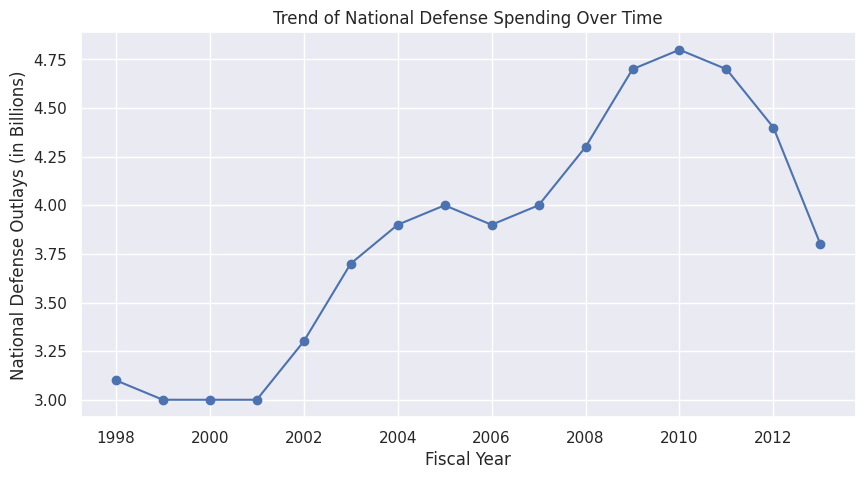

In [0]:
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
df_defense_spending_pd = df_defense_spending_cleaned.toPandas()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_defense_spending_pd["fiscal_year"], df_defense_spending_pd["national_defense_outlays"], marker="o", linestyle="-")
plt.xlabel("Fiscal Year")
plt.ylabel("National Defense Outlays (in Billions)")
plt.title("Trend of National Defense Spending Over Time")
plt.grid(True)
plt.show()


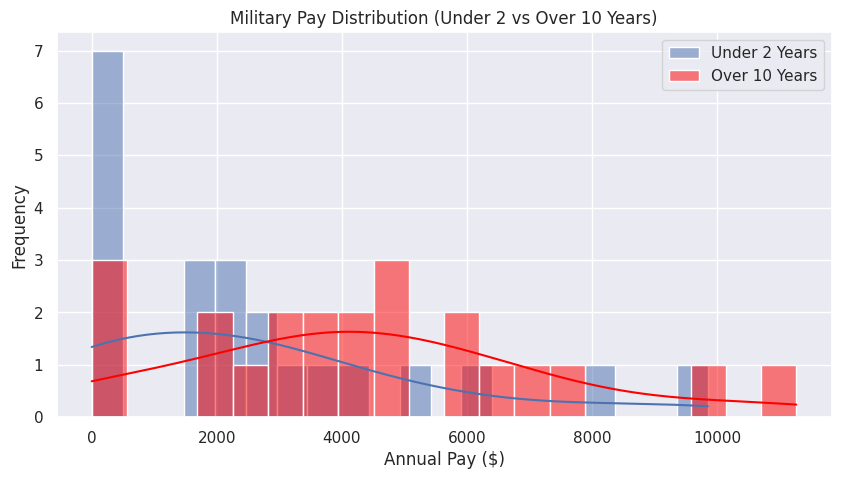

In [0]:
plt.figure(figsize=(10,5))
sns.histplot(df_officer_pay_pd["pay_under_2"], bins=20, kde=True, label="Under 2 Years")
sns.histplot(df_officer_pay_pd["pay_over_10"], bins=20, kde=True, label="Over 10 Years", color="red")
plt.xlabel("Annual Pay ($)")
plt.ylabel("Frequency")
plt.title("Military Pay Distribution (Under 2 vs Over 10 Years)")
plt.legend()
plt.show()


/root/.ipykernel/908/command-718498739267219-3163187588:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_budget_pd.corr(), annot=True, cmap="coolwarm", fmt=".2f")


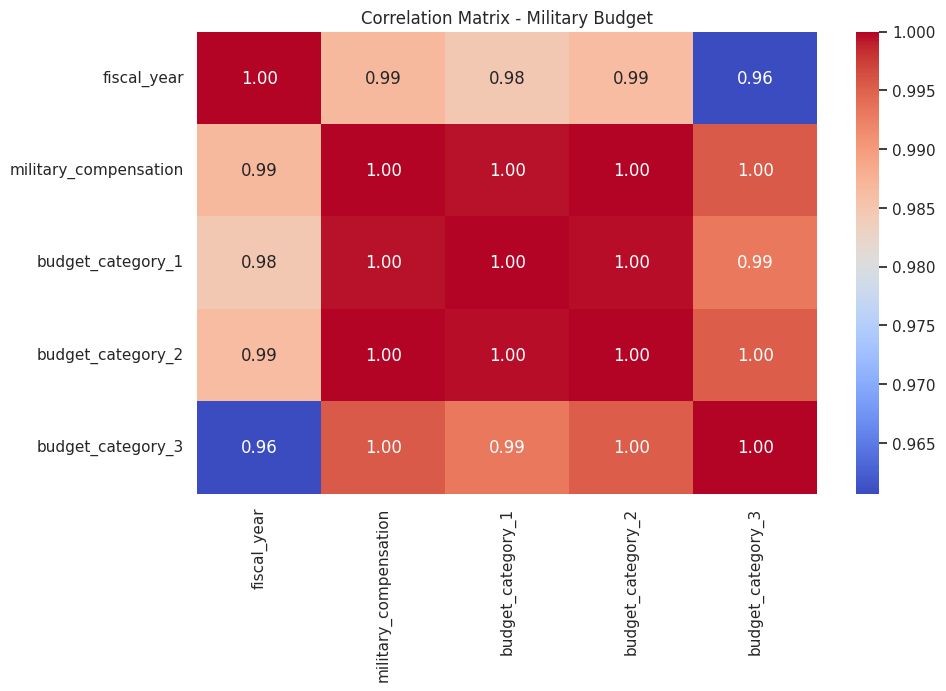

In [0]:
plt.figure(figsize=(10,6))
sns.heatmap(df_budget_pd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - Military Budget")
plt.show()


In [0]:
print(df_airforce_personnel_pd.columns)
print(df_airforce_personnel_pd.dtypes)
print(df_airforce_personnel_pd.head())


Index(['_c0', '_c1'], dtype='object')
_c0    object
_c1    object
dtype: object
    _c0    _c1
0  1998  4,447
1  1999  4,413
2  2000  4,401
3  2001  4,339
4  2002  4,387


In [0]:
# Rename columns to correct names
df_airforce_personnel_pd = df_airforce_personnel_pd.rename(columns={"_c0": "fiscal_year", "_c1": "regular_air_force"})

# Remove commas and convert to numeric
df_airforce_personnel_pd["fiscal_year"] = pd.to_numeric(df_airforce_personnel_pd["fiscal_year"], errors='coerce')
df_airforce_personnel_pd["regular_air_force"] = pd.to_numeric(df_airforce_personnel_pd["regular_air_force"].str.replace(",", ""), errors='coerce')

# Drop any rows with NaN values (if any)
df_airforce_personnel_pd = df_airforce_personnel_pd.dropna()

# Verify the changes
print(df_airforce_personnel_pd.dtypes)
print(df_airforce_personnel_pd.head())


fiscal_year          int64
regular_air_force    int64
dtype: object
   fiscal_year  regular_air_force
0         1998               4447
1         1999               4413
2         2000               4401
3         2001               4339
4         2002               4387


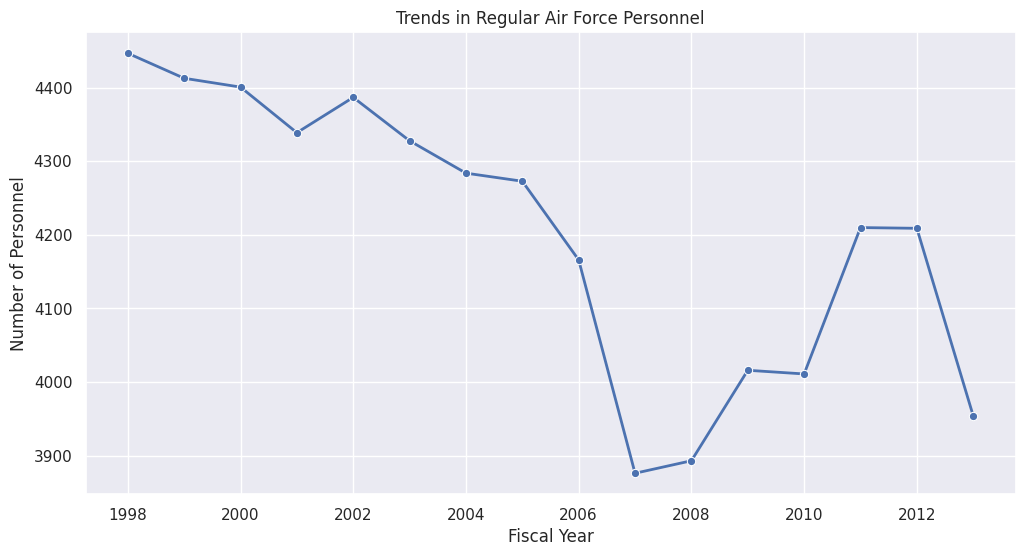

In [0]:
plt.figure(figsize=(12,6))
sns.lineplot(x="fiscal_year", y="regular_air_force", data=df_airforce_personnel_pd, marker="o", linewidth=2)
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Personnel")
plt.title("Trends in Regular Air Force Personnel")
plt.grid(True)
plt.show()


Machine Learning Models 

In [0]:
df_airforce_personnel_parquet = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_personnel_cleaned.parquet")

df_airforce_personnel_parquet.show(10)
df_airforce_personnel_parquet.printSchema()



+----+-----+
| _c0|  _c1|
+----+-----+
|1998|4,447|
|1999|4,413|
|2000|4,401|
|2001|4,339|
|2002|4,387|
|2003|4,328|
|2004|4,284|
|2005|4,273|
|2006|4,166|
|2007|3,876|
+----+-----+
only showing top 10 rows

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [0]:
df_airforce_personnel_cleaned.show(10)
df_airforce_personnel_cleaned.printSchema()


+-----------+-----------------+
|fiscal_year|regular_air_force|
+-----------+-----------------+
+-----------+-----------------+

root
 |-- fiscal_year: integer (nullable = true)
 |-- regular_air_force: integer (nullable = true)



^^df here is incorrectly pre-processed, using parquet instead

In [0]:
from pyspark.sql.functions import col, regexp_replace

# Read from Parquet
df_airforce_personnel_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_personnel_cleaned.parquet")

# Rename columns if needed
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.withColumnRenamed("_c0", "fiscal_year") \
                                                             .withColumnRenamed("_c1", "regular_air_force")

# Remove commas and convert data types
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("regular_air_force", regexp_replace(col("regular_air_force"), ",", "").cast("int"))

# Drop rows where conversion resulted in nulls
df_airforce_personnel_cleaned = df_airforce_personnel_cleaned.dropna()

# Show results
df_airforce_personnel_cleaned.show(10)
df_airforce_personnel_cleaned.printSchema()

# Save cleaned data back to Parquet
df_airforce_personnel_cleaned.write.mode("overwrite").parquet("dbfs:/FileStore/cleaned_data/airforce_personnel_cleaned.parquet")


+-----------+-----------------+
|fiscal_year|regular_air_force|
+-----------+-----------------+
|       1998|             4447|
|       1999|             4413|
|       2000|             4401|
|       2001|             4339|
|       2002|             4387|
|       2003|             4328|
|       2004|             4284|
|       2005|             4273|
|       2006|             4166|
|       2007|             3876|
+-----------+-----------------+
only showing top 10 rows

root
 |-- fiscal_year: integer (nullable = true)
 |-- regular_air_force: integer (nullable = true)



SUPER BASIC REGRESSION MODEL 

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Read from Parquet
df_airforce_personnel_cleaned = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_personnel_cleaned.parquet")

# Prepare features for MLlib
assembler = VectorAssembler(inputCols=["fiscal_year"], outputCol="features")
df_airforce_personnel_vector = assembler.transform(df_airforce_personnel_cleaned)

# Train-test split (80%-20%)
train_data, test_data = df_airforce_personnel_vector.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="regular_air_force")
model = lr.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="regular_air_force", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Show predictions
predictions.select("fiscal_year", "regular_air_force", "prediction").show(10)



Root Mean Squared Error (RMSE): 111.65372455207722
+-----------+-----------------+------------------+
|fiscal_year|regular_air_force|        prediction|
+-----------+-----------------+------------------+
|       2000|             4401|    4368.095395728|
|       2004|             4284|4232.5046644601825|
|       2006|             4166| 4164.709298826259|
|       2011|             4210|3995.2208847414877|
+-----------+-----------------+------------------+



PREDICTING DEFENSE SPENDING USING A REGRESSION 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("DefenseOutlaysRegression").getOrCreate()

# Load the Parquet file
df_payments = spark.read.parquet("dbfs:/FileStore/cleaned_data/defense_spending_cleaned.parquet")

# Rename columns if necessary (adjust based on actual schema)
df_payments = df_payments.withColumnRenamed("_c0", "fiscal_year") \
                         .withColumnRenamed("_c1", "national_defense_outlays")

# Convert data types (remove commas from numbers if present)
df_payments = df_payments \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("national_defense_outlays", regexp_replace(col("national_defense_outlays"), ",", "").cast("double"))

# Drop null values
df_payments = df_payments.dropna()

# Prepare features for MLlib
assembler = VectorAssembler(inputCols=["fiscal_year"], outputCol="features")
df_payments_vector = assembler.transform(df_payments)

# Train-test split (80%-20%)
train_data, test_data = df_payments_vector.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="national_defense_outlays")
model = lr.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Show predictions
predictions.select("fiscal_year", "national_defense_outlays", "prediction").show(10)

# Forecast future values (optional)
future_years = [(year,) for year in range(2025, 2035)]
future_df = spark.createDataFrame(future_years, ["fiscal_year"])
future_df = assembler.transform(future_df)

future_predictions = model.transform(future_df)
future_predictions.select("fiscal_year", "prediction").show()



Root Mean Squared Error (RMSE): 0.22419178410291074
+-----------+------------------------+------------------+
|fiscal_year|national_defense_outlays|        prediction|
+-----------+------------------------+------------------+
|       2000|                     3.0|3.2567860367099115|
|       2004|                     3.9|3.6758049954848957|
|       2006|                     3.9| 3.885314474872388|
|       2011|                     4.7| 4.409088173341132|
+-----------+------------------------+------------------+

+-----------+------------------+
|fiscal_year|        prediction|
+-----------+------------------+
|       2025| 5.875654529053605|
|       2026| 5.980409268747337|
|       2027| 6.085164008441097|
|       2028| 6.189918748134829|
|       2029|6.2946734878285895|
|       2030| 6.399428227522321|
|       2031| 6.504182967216082|
|       2032| 6.608937706909813|
|       2033| 6.713692446603574|
|       2034|6.8184471862973055|
+-----------+------------------+



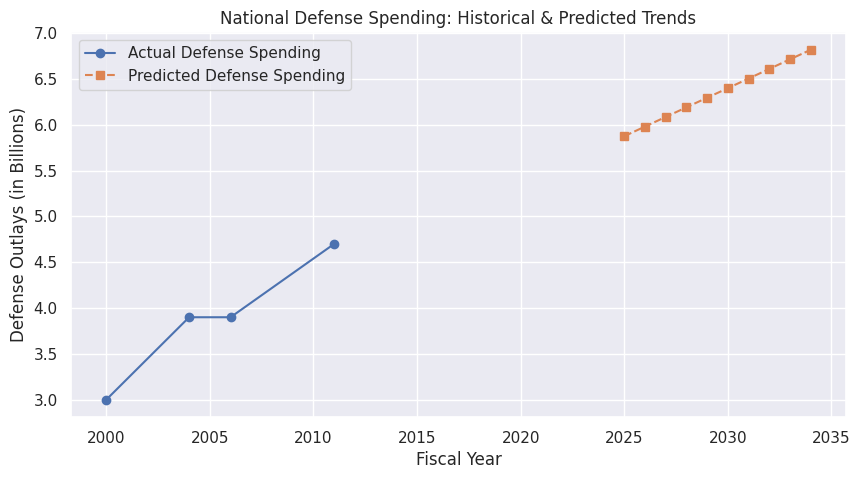

In [0]:
# Re-import necessary libraries since execution state was reset
import matplotlib.pyplot as plt

# Re-define data
actual_years = [2000, 2004, 2006, 2011]
actual_values = [3.0, 3.9, 3.9, 4.7]

# Predicted Future Data
future_years = list(range(2025, 2035))
future_predictions = [5.875, 5.980, 6.085, 6.190, 6.295, 6.399, 6.504, 6.609, 6.714, 6.818]

# Create visualization
plt.figure(figsize=(10, 5))
plt.plot(actual_years, actual_values, marker="o", linestyle="-", label="Actual Defense Spending")
plt.plot(future_years, future_predictions, marker="s", linestyle="--", label="Predicted Defense Spending")

plt.xlabel("Fiscal Year")
plt.ylabel("Defense Outlays (in Billions)")
plt.title("National Defense Spending: Historical & Predicted Trends")
plt.legend()
plt.grid(True)

plt.show()


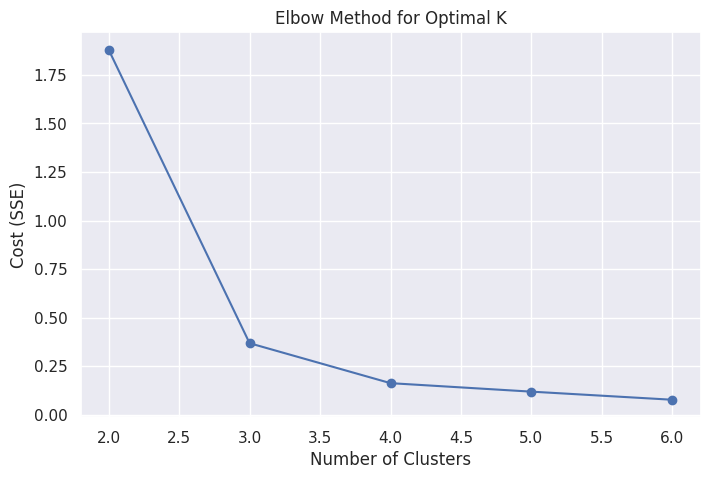

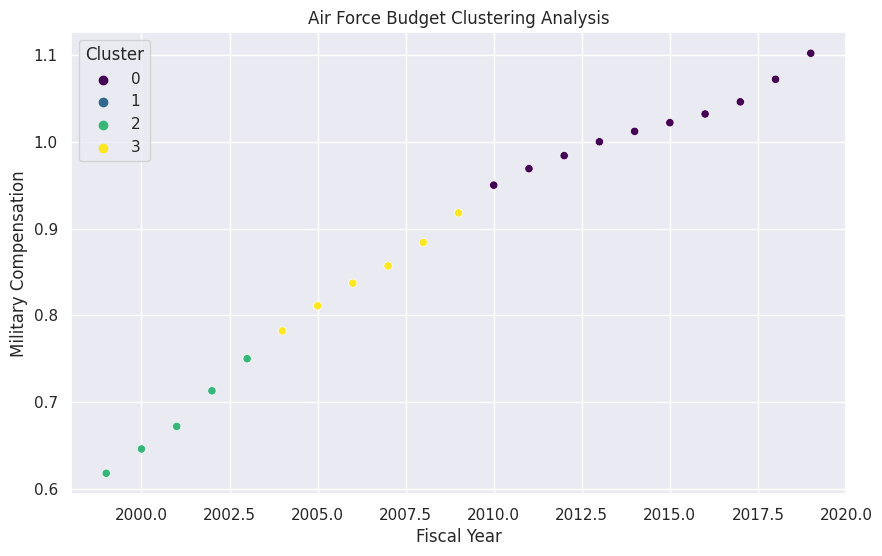

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from Parquet
df_airforce_budget = spark.read.parquet("dbfs:/FileStore/cleaned_data/airforce_budget_cleaned.parquet")

# Prepare features for clustering
assembler = VectorAssembler(inputCols=["military_compensation", "budget_category_1", "budget_category_2", "budget_category_3"], 
                            outputCol="features")
df_airforce_budget_vector = assembler.transform(df_airforce_budget)

# Determine optimal number of clusters using Elbow Method
cost = []
for k in range(2, 7):
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(df_airforce_budget_vector)
    cost.append(model.summary.trainingCost)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 7), cost, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters")
plt.ylabel("Cost (SSE)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

# Train K-Means clustering model with optimal K (Assuming K=4 from Elbow Method)
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df_airforce_budget_vector)
df_clustered = model.transform(df_airforce_budget_vector)

# Convert to Pandas for visualization
df_clustered_pd = df_clustered.select("fiscal_year", "military_compensation", "cluster").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="fiscal_year", y="military_compensation", hue="cluster", data=df_clustered_pd, palette="viridis")
plt.xlabel("Fiscal Year")
plt.ylabel("Military Compensation")
plt.title("Air Force Budget Clustering Analysis")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Adding cross validation to second regression model 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark session
spark = SparkSession.builder.appName("DefenseOutlaysRegression").getOrCreate()

# Load the Parquet file
df_payments = spark.read.parquet("dbfs:/FileStore/cleaned_data/defense_spending_cleaned.parquet")

# Rename columns if necessary (adjust based on actual schema)
df_payments = df_payments.withColumnRenamed("_c0", "fiscal_year") \
                         .withColumnRenamed("_c1", "national_defense_outlays")

# Convert data types (remove commas from numbers if present)
df_payments = df_payments \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("national_defense_outlays", regexp_replace(col("national_defense_outlays"), ",", "").cast("double"))

# Drop null values
df_payments = df_payments.dropna()

# Prepare features for MLlib
assembler = VectorAssembler(inputCols=["fiscal_year"], outputCol="features")
df_payments_vector = assembler.transform(df_payments)

# Train-test split (80%-20%)
train_data, test_data = df_payments_vector.randomSplit([0.8, 0.2], seed=42)

# Define Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="national_defense_outlays")

# Hyperparameter tuning using CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0])  # Regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # ElasticNet mixing param
             .build())

# Define evaluator for RMSE
evaluator = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse")

# Perform Cross Validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Train the best model
cvModel = crossval.fit(train_data)

# Best model selection
bestModel = cvModel.bestModel
print(f"Best Model Params: regParam={bestModel._java_obj.getRegParam()}, elasticNetParam={bestModel._java_obj.getElasticNetParam()}")

# Predictions
predictions = bestModel.transform(test_data)

# Evaluate model performance
rmse = evaluator.evaluate(predictions)
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")

# Show predictions
predictions.select("fiscal_year", "national_defense_outlays", "prediction").show(10)

# Forecast future values (optional)
future_years = [(year,) for year in range(2025, 2035)]
future_df = spark.createDataFrame(future_years, ["fiscal_year"])
future_df = assembler.transform(future_df)

future_predictions = bestModel.transform(future_df)
future_predictions.select("fiscal_year", "prediction").show()


Best Model Params: regParam=0.01, elasticNetParam=0.0
Optimized Root Mean Squared Error (RMSE): 0.22922371710227815
+-----------+------------------------+------------------+
|fiscal_year|national_defense_outlays|        prediction|
+-----------+------------------------+------------------+
|       2000|                     3.0| 3.266174231642907|
|       2004|                     3.9|3.6784673194211166|
|       2006|                     3.9|3.8846138633102214|
|       2011|                     4.7| 4.399980223032969|
+-----------+------------------------+------------------+

+-----------+-----------------+
|fiscal_year|       prediction|
+-----------+-----------------+
|       2025|5.843006030256646|
|       2026|5.946079302201184|
|       2027|6.049152574145751|
|       2028|6.152225846090289|
|       2029|6.255299118034856|
|       2030|6.358372389979394|
|       2031|6.461445661923932|
|       2032|6.564518933868499|
|       2033|6.667592205813037|
|       2034|6.770665477757603|
+--

AUTOMATING ML PROCESS 

In [0]:
%pip install mlflow


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 123.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 51.9 MB/s eta 0:00:00
     ━━

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# Initialize Spark session
spark = SparkSession.builder.appName("DefenseSpendingMLPipeline").getOrCreate()

# Load data from Parquet
df_payments = spark.read.parquet("dbfs:/FileStore/cleaned_data/defense_spending_cleaned.parquet")

# Rename and preprocess data
df_payments = df_payments.withColumnRenamed("_c0", "fiscal_year") \
                         .withColumnRenamed("_c1", "national_defense_outlays")

df_payments = df_payments \
    .withColumn("fiscal_year", col("fiscal_year").cast("int")) \
    .withColumn("national_defense_outlays", regexp_replace(col("national_defense_outlays"), ",", "").cast("double"))

df_payments = df_payments.dropna()

# Assemble feature vector
assembler = VectorAssembler(inputCols=["fiscal_year"], outputCol="features")

def train_model(model_type, degree=1):
    """Train and log models using MLflow."""
    with mlflow.start_run():
        # Define model pipeline
        if model_type == "linear":
            model = LinearRegression(featuresCol="features", labelCol="national_defense_outlays", regParam=0.01, elasticNetParam=0.0)
            pipeline = Pipeline(stages=[assembler, model])
        elif model_type == "polynomial":
            polyExpansion = PolynomialExpansion(inputCol="features", outputCol="polyFeatures", degree=degree)
            model = LinearRegression(featuresCol="polyFeatures", labelCol="national_defense_outlays", regParam=0.01, elasticNetParam=0.0)
            pipeline = Pipeline(stages=[assembler, polyExpansion, model])
        else:
            raise ValueError("Unsupported model type")
        
        # Train model
        train_data, test_data = df_payments.randomSplit([0.8, 0.2], seed=42)
        trained_pipeline = pipeline.fit(train_data)
        predictions = trained_pipeline.transform(test_data)
        
        # Evaluate model
        evaluator = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        
        # Log parameters and metrics
        mlflow.log_param("model_type", model_type)
        mlflow.log_param("degree", degree)
        mlflow.log_metric("rmse", rmse)
        
        # Log model
        mlflow.spark.log_model(trained_pipeline, "model")
        
        print(f"Trained {model_type} regression model (Degree: {degree}) with RMSE: {rmse}")

# Train and track Linear Regression model
train_model("linear")

# Train and track Polynomial Regression model (degree=2)
train_model("polynomial", degree=2)

# Train and track Polynomial Regression model (degree=3)
train_model("polynomial", degree=3)


2025/03/04 00:36:29 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:36:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/718498739267123/1c1be85a6fd442b2844e95a8dbb5c989/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


Trained linear regression model (Degree: 1) with RMSE: 0.22922371710227815


2025/03/04 00:37:07 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:37:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/718498739267123/7c1bade3f90c438b9b0718a72fc118be/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


Trained polynomial regression model (Degree: 2) with RMSE: 0.22684156316345755


2025/03/04 00:37:44 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:38:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/718498739267123/9572bea9c18f4c90a087786be3e1a26d/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


Trained polynomial regression model (Degree: 3) with RMSE: 0.2261241413468267


USED ML flow to track three different regression models 

In [0]:
import mlflow
from databricks.sdk.runtime import dbutils

# ✅ Define Experiment Name
experiment_name = "/Users/debray@purdue.edu/Defense_Air_Force_Spending"

# ✅ Check if Experiment Exists
existing_experiment = mlflow.get_experiment_by_name(experiment_name)

if existing_experiment is None:
    # ✅ Create the Experiment
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment: {experiment_name}")
else:
    experiment_id = existing_experiment.experiment_id
    print(f"Using existing experiment: {experiment_name}")

# ✅ Now Set the Experiment
mlflow.set_experiment(experiment_name)

print(f"Experiment is set: {experiment_name}")


Created new experiment: /Users/debray@purdue.edu/Defense_Air_Force_Spending
Experiment is set: /Users/debray@purdue.edu/Defense_Air_Force_Spending


In [0]:
import mlflow
import mlflow.spark
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# ✅ Ensure Experiment is Set
mlflow.set_experiment("/Users/debray@purdue.edu/Defense_Air_Force_Spending")

with mlflow.start_run():
    # ✅ Log Parameters
    mlflow.log_param("model_type", "LinearRegression")

    # ✅ Prepare Features
    assembler = VectorAssembler(inputCols=["fiscal_year"], outputCol="features")
    
    # ✅ Define Model
    lr = LinearRegression(featuresCol="features", labelCol="national_defense_outlays")
    
    # ✅ Create Pipeline
    pipeline = Pipeline(stages=[assembler, lr])
    
    # ✅ Train Model
    model = pipeline.fit(train_data)

    # ✅ Log Model
    mlflow.spark.log_model(model, "model")

    # ✅ Predictions & Evaluation
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # ✅ Log Metrics
    mlflow.log_metric("rmse", rmse)

    print(f"Trained model with RMSE: {rmse}")

# ✅ Show Predictions
predictions.select("fiscal_year", "national_defense_outlays", "prediction").show(10)




2025/03/04 00:48:32 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:48:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/2424288302878693/26299fcfec9c45eba85504bbe4e0d3fe/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


Trained model with RMSE: 0.22419178410291074
+-----------+------------------------+------------------+
|fiscal_year|national_defense_outlays|        prediction|
+-----------+------------------------+------------------+
|       2000|                     3.0|3.2567860367099115|
|       2004|                     3.9|3.6758049954848957|
|       2006|                     3.9| 3.885314474872388|
|       2011|                     4.7| 4.409088173341132|
+-----------+------------------------+------------------+



Polynomial Regression to compare 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# ✅ Step 1: Load Data from Parquet
df_payments = spark.read.parquet("dbfs:/FileStore/cleaned_data/defense_spending_cleaned.parquet")

# ✅ Step 2: Rename & Convert Data Types
df_payments = df_payments.withColumnRenamed("_c0", "fiscal_year") \
                         .withColumnRenamed("_c1", "national_defense_outlays")

df_payments = df_payments.withColumn("fiscal_year", col("fiscal_year").cast("int")) \
                         .withColumn("national_defense_outlays", col("national_defense_outlays").cast("double"))

df_payments = df_payments.dropna()

# ✅ Step 3: Generate Polynomial Features (Degree 2 & 3)
df_poly2 = df_payments.withColumn("fiscal_year_sq", pow(col("fiscal_year"), 2))
df_poly3 = df_poly2.withColumn("fiscal_year_cube", pow(col("fiscal_year"), 3))

# ✅ Step 4: Assemble Features
assembler2 = VectorAssembler(inputCols=["fiscal_year", "fiscal_year_sq"], outputCol="features")
assembler3 = VectorAssembler(inputCols=["fiscal_year", "fiscal_year_sq", "fiscal_year_cube"], outputCol="features")

df_poly2 = assembler2.transform(df_poly2)
df_poly3 = assembler3.transform(df_poly3)

# ✅ Step 5: Train-Test Split
train_data2, test_data2 = df_poly2.randomSplit([0.8, 0.2], seed=42)
train_data3, test_data3 = df_poly3.randomSplit([0.8, 0.2], seed=42)

# ✅ Step 6: Train Polynomial Regression Models
lr = LinearRegression(featuresCol="features", labelCol="national_defense_outlays")

mlflow.set_experiment("/Users/debray@purdue.edu/Defense_Air_Force_Spending")

# Train and log models
with mlflow.start_run(run_name="Polynomial_Regression_Degree_2"):
    model2 = lr.fit(train_data2)
    predictions2 = model2.transform(test_data2)
    rmse2 = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse").evaluate(predictions2)

    mlflow.log_param("degree", 2)
    mlflow.log_metric("rmse", rmse2)
    mlflow.spark.log_model(model2, "model_poly2")

with mlflow.start_run(run_name="Polynomial_Regression_Degree_3"):
    model3 = lr.fit(train_data3)
    predictions3 = model3.transform(test_data3)
    rmse3 = RegressionEvaluator(labelCol="national_defense_outlays", predictionCol="prediction", metricName="rmse").evaluate(predictions3)

    mlflow.log_param("degree", 3)
    mlflow.log_metric("rmse", rmse3)
    mlflow.spark.log_model(model3, "model_poly3")

# ✅ Step 7: Compare Model Performance
rmse2, rmse3


2025/03/04 00:56:35 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:56:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/2424288302878693/a683ae0ac3094b508ca86028cfae488e/artifacts/model_poly2/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/04 00:57:06 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/04 00:57:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model UR

(0.22995014688238968, 0.22444664225112668)